In [1]:
"""
This is a template algorithm on Quantopian for you to adapt and fill in.
"""
#import quantopian.algorithm as algo
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import QTradableStocksUS

# MY IMPORTS START
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import time
import alphalens
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage , Returns

In [2]:
class Momentum(CustomFactor):
    
    inputs = [USEquityPricing.close]
    window_length = 252
    
    def compute(self, today, assets, out, close):       
        out[:] = close[-20] / close[0]
        
class MamaReturns(CustomFactor):
    
    inputs = [USEquityPricing.close]
    window_length = 252
    
    def compute(self, today, assets, out, close):       
        out[:] =  close[0] - close[-5]     
        
class Volatility(CustomFactor):
    
    inputs = [USEquityPricing.close]
    window_length = 252
    
    def compute(self, today, assets, out, close):  
        close = pd.DataFrame(data=close, columns=assets) 
        # Since we are going to rank largest is best we need to invert the sdev.
        out[:] = 1 / np.log(close).diff().std()

# MY COSTOM CLASS END

In [3]:
def make_pipeline():
    """
    A function to create our dynamic stock selector (pipeline). Documentation
    on pipeline can be found here:
    https://www.quantopian.com/help#pipeline-title
    """
    
    # Base universe set to the QTradableStocksUS
    base_universe = QTradableStocksUS()

    # Factor of yesterday's close price.
    yesterday_close = USEquityPricing.close.latest
    
    
    returns= Returns(window_length=215)
    
    # Custom factors    
    average_day_dv_200 = AverageDollarVolume(window_length=200)
    market_cap = Fundamentals.market_cap.latest
    price = USEquityPricing.close.latest
    volume = USEquityPricing.volume.latest
    volitility = Volatility()
    sector = Sector()
    momentum = Momentum()
    

    ''' price momentum and voli
        sector momentum and voli '''
    
    pipe = Pipeline(
        columns={
            'close': yesterday_close,
            'AverageDollarVolume200': average_day_dv_200,
            'MarketCap': market_cap,
            'Price': price,
            'Volume': volume,
            'Sector': sector,
            'volitility': volitility,
            'momentum': momentum ,
            'returns' : returns
        },
        screen=base_universe
    )
    return pipe


In [4]:
pipe= run_pipeline(make_pipeline(), start_date='2015-01-01',end_date='2015-12-01' )
np.shape(pipe)


(491510, 9)

In [5]:
type(pipe)

<class 'pandas.core.frame.DataFrame'>

In [6]:
pipe.columns

Index([u'AverageDollarVolume200', u'MarketCap', u'Price', u'Sector', u'Volume',
       u'close', u'momentum', u'returns', u'volitility'],
      dtype='object')

In [7]:
results_backup = pipe.copy()
returns = results_backup.pop('returns')

In [8]:
np.shape(returns)

(491510,)

In [9]:
#what the reference code did 
#X = results_backup.to_panel() 
#np.shape(X)
#X = X.swapaxes(2, 0).swapaxes(0, 1).values
#np.shape(X)
#day , stock , features = np.shape(X)
 #X = X.reshape((day * stock, features))

In [10]:
#what i simply did
X = results_backup.values 
np.shape(X)


(491510, 8)

In [11]:
X.shape

(491510, 8)

In [12]:
X

array([[  2.46638183e+08,   1.86136084e+10,   1.58000000e+01, ...,
          1.58000000e+01,   1.64755871e+00,   5.28617723e+01],
       [  4.41388060e+09,   6.47361039e+11,   1.10430000e+02, ...,
          1.10430000e+02,   1.49769743e+00,   7.33571099e+01],
       [  6.64043922e+06,   1.28072088e+09,   5.67300000e+01, ...,
          5.67300000e+01,   1.45783373e+00,   5.47838435e+01],
       ..., 
       [  1.67289886e+07,   1.87049548e+09,   1.67600000e+01, ...,
          1.67600000e+01,              nan,   5.95131467e+01],
       [  1.02347930e+07,   2.80034145e+09,   1.85500000e+01, ...,
          1.85500000e+01,              nan,   2.95904726e+01],
       [  1.22977485e+07,   2.34740564e+09,   2.27600000e+01, ...,
          2.27600000e+01,              nan,   3.93761787e+01]])

In [13]:
returns=returns.fillna(returns.mean())

In [14]:
Y=returns.values
print(np.shape(Y))
Y

(491510,)


array([ 0.31895578,  0.51655245,  0.47675894, ...,  0.07848518,
        0.07848518,  0.07848518])

In [15]:

#Taking care of missing values
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values = 'NaN',strategy = 'median',axis=0)
imputer = imputer.fit(X[:,:]) #SELECTING THE COLUMN WITH MISSING VALUES
X[:,:] = imputer.transform(X[:,:])

In [16]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * X.shape[0])
train_features = X[0: train_size]
train_targets = Y[0:train_size]
test_features = X[train_size:]
test_targets = Y[train_size:]
print(X.shape, train_features.shape, test_features.shape)

((491510, 8), (417783, 8), (73727, 8))


In [17]:
X_train=train_features
y_train=train_targets
X_test=test_features
y_test=test_targets

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
regress = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 5, 
                                    min_samples_split= 5, n_estimators= 40, subsample= 0.9)

regress.fit(X_train, y_train)
y_pred = regress.predict(X_test)
y_pred
#o = accuracy_score(y_test, y_pred1)
#print(o)
#rmse1 = np.sqrt(mean_squared_error(y_test,y_pred1))
#mae1=mean_absolute_error(y_test,y_pred)
#print("rmse for XGBRegressor: ",rmse1)
#print("MAE for XGBRegressor: ",mae1)


array([ 0.20902634,  0.09230897,  0.18534665, ...,  0.07707727,
        0.1207187 ,  0.05869638])

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print("rmse for linear regression: ",rmse)
print("MAE for linear regression: ",mae)

('rmse for linear regression: ', 0.19247463513382335)
('MAE for linear regression: ', 0.12250227592491449)


In [19]:
####################now we test with Scaling the features#########################

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
regress = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 5, 
                                    min_samples_split= 5, n_estimators= 40, subsample= 0.9)

regress.fit(X_train, y_train)
y_pred = regress.predict(X_test)

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print("After scaling rmse for linear regression: ",rmse)
print("After scaling MAE for linear regression: ",mae)

('After scaling rmse for linear regression: ', 0.19143227065287516)
('After scaling MAE for linear regression: ', 0.12240469399840916)


1.0
0.656093080472


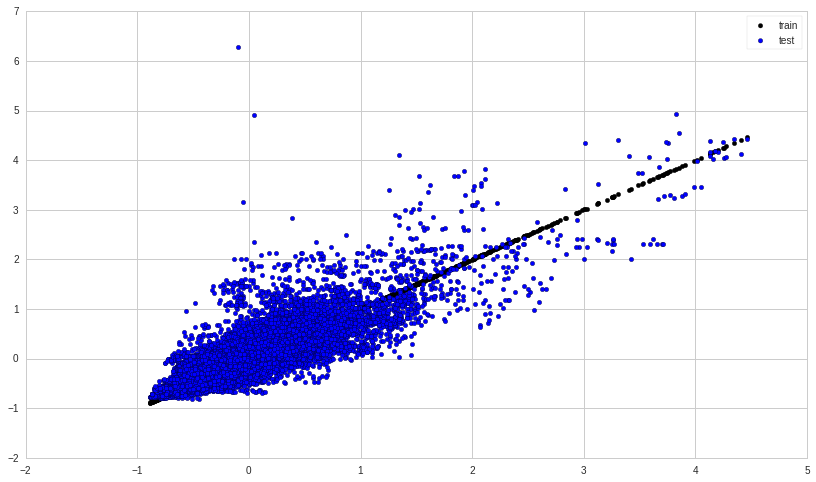

In [29]:
from sklearn.metrics import r2_score

print(r2_score(y_train, y_train))
print(r2_score(y_test, y_pred))

# Plot predictions vs actual
plt.scatter(y_test, y_test, label='train', color='black')
plt.scatter(y_test, y_pred , label='test')
plt.legend()
plt.show()

In [22]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))


SandboxViolation: Importing Sequential from keras.models raised an ImportError. No modules or attributes with a similar name were found.

In [23]:
model_1.compile(optimizer='adam', loss='mean_squared_error')
model_1.fit(X_train, y_train, epochs=25)

y_pred1 = model_1.predict(X_test)
print(y_pred1)


SandboxViolation: Blacklisted attribute within module compile

In [24]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds , test_targets , label='test')
plt.legend()
plt.show()

NameError: name 'model_1' is not defined

In [30]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor()
clf.fit(X_train, y_train)
y_pred = regress.predict(X_test)

SandboxViolation: Importing MLPRegressor from sklearn.neural_network raised an ImportError. No modules or attributes with a similar name were found. Our security system is concerned. If you continue to have import errors, your account will be suspended until a human can talk to you. 

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)
print("After scaling rmse for linear regression: ",rmse)
print("After scaling MAE for linear regression: ",mae)

('After scaling rmse for linear regression: ', 0.19143227065287516)
('After scaling MAE for linear regression: ', 0.12240469399840916)


1.0
0.656093080472


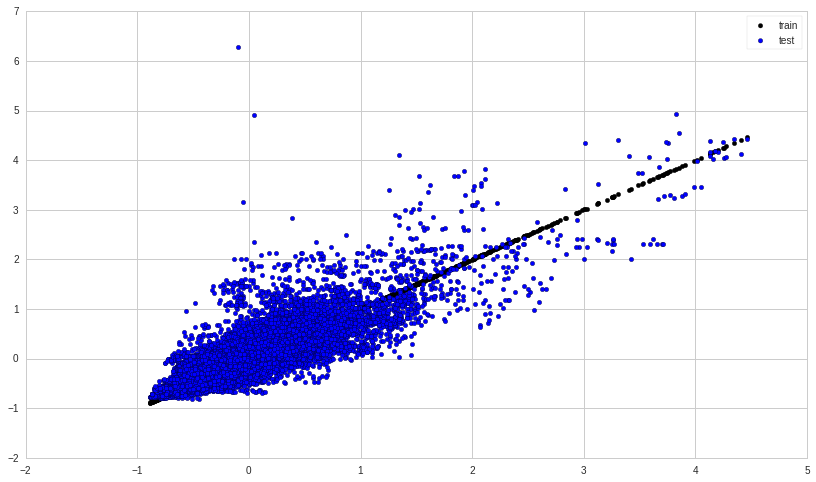

In [32]:
from sklearn.metrics import r2_score

print(r2_score(y_train, y_train))
print(r2_score(y_test, y_pred))

# Plot predictions vs actual
plt.scatter(y_test, y_test, label='train', color='black')
plt.scatter(y_test, y_pred , label='test')
plt.legend()
plt.show()

In [33]:
y_pred

array([ 0.20329963,  0.09023004,  0.18436713, ...,  0.07300674,
        0.12995063,  0.05537989])